# Research Notebook: Running test cases on CFMiso to probe its abilities and limits
## 20240315 mst

Here we will curate some initial surface conditions, and test the limits of the firn depth for this model.

Input/output will be saved the ./CommunityFirnModel/data folder 

In [2]:
### Import necessary python packages and CFM code.
# import statsmodels.api as sm
import h5py as h5
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import netCDF4 as nc
import sys
import os
import pickle
import seaborn as sns 
import glob
from datetime import datetime, timedelta, date
import time
import json
import shutil
import xarray as xr
import copy

SPY = 365.25*24*3600

from firn_density_nospin import FirnDensityNoSpin
from siteClimate_from_RCM import getClimate #get data from RCM
from RCMpkl_to_spin import makeSpinFiles

In [3]:
### Set plot parameters (seaborn, matplotlib)
sb=True
if sb:
    sns.set()
    sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 1.5})
#     sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set_style("whitegrid",{"xtick.top":True, "xtick.bottom":True,"ytick.left":True, "ytick.right":True})
# plt.style.use('seaborn-notebook')

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams.update({'figure.autolayout': True})
fontsz = 20

In [4]:
### This function contains all of the CFM configuration options.
### The values here are more or less the defaults.
### You can change them here if you want to change default settings,
### but if you want to change on a run-by-run basis I recommend doing so in the cell below.

# doublegrid to True - turning on double grid routine (for faster running of things, allowing thicker firn column without much higher run times).

def makejson():
    false = False
    true = True
    c = {
    "InputFileFolder": "CFMinput",
    "InputFileNameTemp": "example_tskin.csv",
    "InputFileNamebdot": "example_smb.csv",
    "InputFileNameIso": "example_isotope.csv",
    "InputFileNamerho": "example_rhos.csv",
    "InputFileNamemelt": "example_melt.csv",
    "resultsFolder": "CFMoutput/test",
    "initfirnFile": "example_firndata.csv",
    "initprofile": false,
    "input_type": "dataframe",
    "input_type_options": ["csv","dataframe"],
    "DFresample": "1D",
    "DFfile": "MERRA2_CLIM_df_72.5_-38.75.pkl",
    "physRho": "GSFC2020",
    "physRho_options":["HLdynamic","HLSigfus","Li2004","Li2011","Helsen2008","Arthern2010S","Arthern2010T","Li2015","Goujon2003","Barnola1991","Morris2014","KuipersMunneke2015","Crocus","Ligtenberg2011"],
    "MELT": false,
    "ReehCorrectedT": false,
    "FirnAir": false,
    "AirConfigName": "AirConfig.json",
    "TWriteInt": 1,
    "TWriteStart": 1980.0,
    "int_type": "nearest",
    "int_type_options": ["nearest","linear"],
    "SeasonalTcycle": false,
    "SeasonalThemi": "north",
    "coreless": true,
    "TAmp":10.0,
    "physGrain": false,
    "calcGrainSize": false,
    "GrGrowPhysics": "Arthern",
    "GrGrowPhysics_options": ["Arthern", "Katsushima"],
    "heatDiff": true,
    "conductivity": "Calonne2019",
    "conductivity_options": ["Schwander","Yen_fixed","Yen_var","Anderson","Yen_b","Sturm","VanDusen","Schwerdtfeger","Riche","Jiawen","mix","Calonne2011","Calonne2019"],
    "variable_srho": false,
    "srho_type": "userinput",
    "srho_type_options": ["userinput","param","noise"],
    "rhos0": 350.0,
    "r2s0": 1.0e-8,
    "AutoSpinUpTime": false,
    "yearSpin": 20,
    "H": 3000,
    "HbaseSpin": 2880.0,
    "stpsPerYear": 12.0,
    "D_surf": 1.0,
    "bdot_type": "mean",
    "bdot_type_options": ["instant","mean","stress"],
    "grid_outputs": false,
    "grid_output_res": 0.25,
    "isoDiff": true,
    "iso": ["d18O","dD"],
    "isoOptions":["d18O","dD","NoDiffusion"],
    "spacewriteint": 1,
    "strain": false,
    "du_dx": 1e-5,
    "outputs": ["density", "depth", "temperature", "age", "DIP","isotopes"],
    "outputs_options": ["density", "depth", "temperature", "age", "Dcon", "bdot_mean", "climate", "compaction", "grainsize", "temp_Hx", "isotopes", "BCO", "DIPc", "DIP", "LWC","gasses", "PLWC_mem", "viscosity", "runoff",
    "refrozen"],
    "resultsFileName": "CFMresults.hdf5",
    "spinFileName": "CFMspin.hdf5",
    "doublegrid": true,
    "nodestocombine": 30,
    "multnodestocombine": 12,
    "Dnodestocombine": 30,
    "Dmultnodestocombine": 12,
    "grid1bottom": 5.0,
    "grid2bottom": 10.0,
    "spinup_climate_type": "mean",
    "spinup_climate_type_options": ["mean", "initial"],
    "manual_climate": false,
    "deepT": 255.88,
    "bdot_long": 0.49073,
    "manual_iceout": false,
    "iceout": 0.23,
    "QMorris": 110.0e3,
    "timesetup": "exact",
    "timesetup_options": ["exact","interp","retmip"],
    "liquid": "bucket",
    "liquid_options": ["percolation_bucket","bucketVV","resingledomain","prefsnowpack"],
    "merging": false,
    "merge_min": 1e-4,
    "LWCcorrect": false,
    "manualT": false,
    "no_densification": false,
    "rad_pen": false,
    "site_pressure": 1013.25,
    "output_bits": "float32",
    "spinUpdate": true,
    "spinUpdateDate": 1980.0,
    "DIPhorizon": 100.0,
    "NewSpin": true,
    "ColeouLesaffre": false,
    "IrrVal": 0.02,
    "RhoImp": 830.0,
    "DownToIce": false,
    "ThickImp": 0.1,
    "Ponding": false,
    "DirectRunoff": 0.0,
    "RunoffZuoOerlemans": false,
    "Slope": 0.1,
    "SUBLIM": True
    }

    return c

In [5]:
### In general, the lat/lon on an RCM grid will not be the same at the '_int' values you enter. If working with RCM data you can 
### write a function to find the grid point closest to the point you entered, and saves it as 'lat_val' and 'lon_val'
### but for now we can just set them equal, and load the .pkl for that point.

lat_int = 72.5 # latitude of interest
lon_int = -36.25 #longitude

lat_val = lat_int
lon_val = lon_int

### load the forcing climate data, which is a dataframe called df_daily.
pklList = os.listdir(homepath)
pklList = [p for p in pklList if p[-3:] == 'pkl']
df_daily = pd.read_pickle(homepath+pklList[0])


In [6]:
### The input dataframe has 4 columns: TS (surface, or skin, temperature); BDOT (snow accumulation); RAIN; SMELT (snowmelt)
### The units for the mass fluxes (I think!) are kg/m^2/day.
df_daily.head()

,TS,EVAP,SMELT,PRECTOT,PRECSNO
time,,,,,
1980-01-01,235.668045,-0.036549,0.0,0.314766,0.314766
1980-01-02,231.323288,-0.035914,0.0,0.120460,0.120460
1980-01-03,234.964981,-0.069931,0.0,0.251130,0.251130
1980-01-04,232.422836,-0.042403,0.0,0.175063,0.175063
1980-01-05,233.590408,-0.082655,0.0,0.182788,0.182788


In [7]:
### The CFM itself (i.e, firn_density_nospin.py) takes inputs as vectors of temperature, accumulation, etc., and decimal time. 
### The following line calls a script that takes the df_daily and creates a python dictionary (called Cd, for climate dictionary)
### containing the vectors that the CFM needs to run. (converts the data from df_daily into these vectors)
### the function also returns some other variables that will be used to configure the CFM run. (but are not important for what you are doing, generally speaking)

### so, if you want to create your own forcing data you can either create a dataframe with a datetime index, which gets turned into the dictionary in the below function call,
### or you could just create a dictionary with the needed keys (['time', 'TSKIN', 'BDOT', 'd18O', 'dD']), where 'time' is decimal date
### we can't use pandas exclusively with datetime indicies because the datetime64 format has limitations

timeres = '1M' # set the time resolution for the model run. '5D' is 5 days, '1M' is one month, etc

Cd, StpsPerYr, depth_S1, depth_S2, grid_bottom = makeSpinFiles(df_daily.copy(),timeres=timeres,Tinterp='mean',spin_date_st = 1980.0, spin_date_end = 1995.0,desired_depth=100)

# set bottom density to be 700-800 kg/m3, rho_bottom = ?,then maybe don't set desired depth
# or set desired_depth to a small depth. 

# lower boundary condition is currently zero gradient, so maybe 
# will not get longer run times for deeper snow, necessarily
# set up sub-grid routine in json 

Cd['d18O'] = 0.62* Cd['TSKIN'] - 15.25 #Johnsen 1989 eq. 2
Cd['dD'] = 8.0 * Cd['d18O'] + 10 #Johnsen 1989 eq. 1

0.1874434
241.15416
df_full (no seb):                   TSKIN    SUBLIM  SMELT  RAIN       BDOT
decdate                                                  
1452.081967  234.408646 -1.683771    0.0   0.0  13.621872
1452.161202  230.663254 -1.133916    0.0   0.0  14.134991
1452.245902  234.648453 -1.356156    0.0   0.0  15.485569
1452.327869  237.161209 -0.482879    0.0   0.0  10.625987
1452.412568  252.897690  0.150575    0.0   0.0  17.677395


In [8]:
Cd

{'time': Float64Index([1452.0819672131147, 1452.1612021857923, 1452.2459016393443,
                1452.327868852459, 1452.4125683060108, 1452.4945355191257,
               1452.5792349726776, 1452.6639344262296, 1452.7459016393443,
               1452.8306010928961,
               ...
               2020.2459016393443,  2020.327868852459, 2020.4125683060108,
               2020.4945355191257, 2020.5792349726776, 2020.6639344262296,
               2020.7459016393443, 2020.8306010928961, 2020.9125683060108,
               2020.9972677595629],
              dtype='float64', name='decdate', length=6828),
 'TSKIN': array([234.4086, 230.6633, 234.6485, ..., 242.2295, 230.8449, 231.2889],
       dtype=float32),
 'SUBLIM': array([-0.022 , -0.0148, -0.0177, ..., -0.022 , -0.0138, -0.0134],
       dtype=float32),
 'SMELT': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'RAIN': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'BDOT': array([0.1783, 0.185 , 0.2027, ..., 0.3717, 0.2422

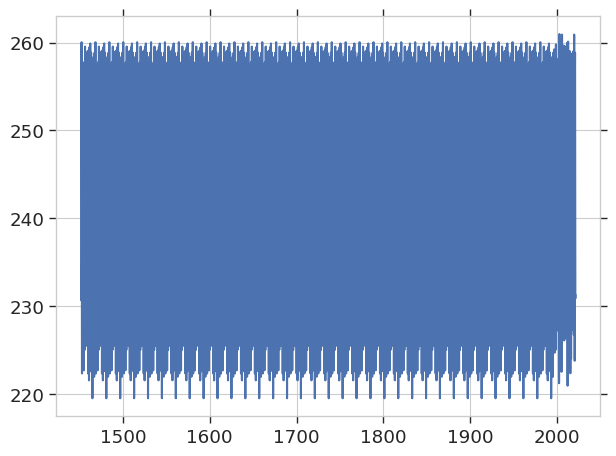

In [18]:
plt.figure()
plt.plot(Cd['time'],Cd['TSKIN'])

In [9]:
### Configure the CFM run.
### the variable 'c' is a dictionary with key-value pairs
### if you want to alter anything in the config file I recommend doing so here.
### note that not all CFM features will work with isotopes turned on - let me know if I need to change anything for you in that regard.

runid=-9999

#######
### Prepare config .json (which is a dictionary called c within this python script) ###
### edit as you wish here (the makejson function above just has defaults, you can change there as well)
c = makejson()
c['physRho'] = 'KuipersMunneke2015' # try with 'GSFC2020' and 'KuipersMunneke2015'
c['runID'] = runid
c['DFresample'] = timeres # resolution of the model run, e.g. '1d' is 1 day.
c["doublegrid"] = False
c['nodestocombine'] = 6 
c['multnodestocombine'] = 12
c['melt'] = False #you can set to false to make things run a lot faster if don't care about results
c["stpsPerYear"] = StpsPerYr
c["stpsPerYearSpin"] = StpsPerYr
c["grid1bottom"] = 5
c["grid2bottom"] = 10
# c["grid1bottom"] = depth_S1
# c["grid2bottom"] = depth_S2
c["HbaseSpin"] = 3000 - grid_bottom
c["DIPhorizon"] = np.floor(0.8*grid_bottom) # firn air content, depth integrated porosity 
c["rhos0"] = 325.0  # e.g here you could change the surface density
#######

### Specify where results should go ###
### alter this to reflect model-run specifics if e.g. you are doing several similar runs just varying one model setting
reDir = f'CFMoutputs/CFMresults_iso_{lat_val}_{lon_val}'
c['resultsFolder'] = reDir
##########

configName = f'CFMconfig_iso_{lat_val}_{lon_val}.json'
if os.path.exists(os.path.join(c['resultsFolder'],configName)):
    CFMconfig = os.path.join(c['resultsFolder'],configName)
    shutil.move(CFMconfig, os.getcwd())
else:
    CFMconfig = configName
with open(CFMconfig,'w') as fp:
    fp.write(json.dumps(c,sort_keys=True, indent=4, separators=(',', ': ')))



In [10]:
c['resultsFolder']

'CFMoutputs/CFMresults_iso_72.5_-36.25'

In [11]:
### start the CFM run
tnow = time.time()
firn = FirnDensityNoSpin(configName,climateTS = Cd, NewSpin = True)
firn.time_evolve()
telap = (time.time()-tnow)/60
print('main done, {} minutes'.format(telap))

shutil.move(configName,reDir)

stepsperyear: 12.000028815260562
Spin run started
physics are KuipersMunneke2015
Grid length is 6454
AHL: 0.18592599034309387
THL: 240.34596252441406
Main run starting
physics are KuipersMunneke2015
updatedStartDate 20.916618841453218
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 1452.0819672131147 2020.9972677595629
estimated model run time (seconds): 90.91926461791992
main done, 1.5781851410865784 minutes


'CFMoutputs/CFMresults_iso_72.5_-36.25/CFMconfig_iso_72.5_-36.25.json'

In [12]:
# what is in this erroneous file?
import h5py
df_out = pd.DataFrame(np.array(h5py.File("./CFMoutputs/CFMresults_iso_72.5_-36.25/CFMspin.hdf5")))
#df_out = pd.read_hdf('./CFMoutputs/CFMresults_iso_72.5_-36.25/CFMspin.hdf5')

df_out

,0
0,IsoSpin_d18O
1,IsoSpin_dD
2,ageSpin
3,bdot_meanSpin
4,densitySpin
5,depthSpin
6,iso_sig2_d18O
7,iso_sig2_dD
8,tempSpin


In [13]:
fns = ['test_run_1']
rd = {} #results dictionary. I use nested dictionaries to load results from several runs in an organized fashion, e.g. 
# Ideally you do this with the naming of results directory above and loop through what you are changing

for rt in fns:
    print(rt)
    rd[rt] = {}
    ff = f'CFMoutputs/CFMresults_iso_72.5_-36.25/CFMresults.hdf5'
    with h5.File(ff,'r') as fn:# Open the CFM results file
        vars_list = list(fn.keys()) # Make a list of the variables stored in the file
        # The first row in each of the model outputs is the initial condition, so we don't want that (i.e. start by using the data in 2nd row)
        # The first column is the time step. So, we use index [1:,1:] on most of the variables to get just the data we want.
        rd[rt]['model_time'] = fn['density'][1:,0] # the first column of the density data is the model time step.
        rd[rt]['depth'] = fn['depth'][1:,1:] # Put the depth data into a numpy array
        rd[rt]['density'] = fn['density'][1:,1:] # Put the density data into an array
        rd[rt]['temperature'] = fn['temperature'][1:,1:]
        rd[rt]['sig2_d18O'] = fn['iso_sig2_d18O'][1:,1:]
        rd[rt]['sig2_dD'] = fn['iso_sig2_dD'][1:,1:]
        rd[rt]['isotopes_d18O'] = fn['isotopes_d18O'][1:,1:]
        rd[rt]['isotopes_dD'] = fn['isotopes_dD'][1:,1:]
        # rd[rt]['DIP'] = fn['DIP'][1:,1:]


test_run_1


Text(0, 0.5, 'Depth (m)')

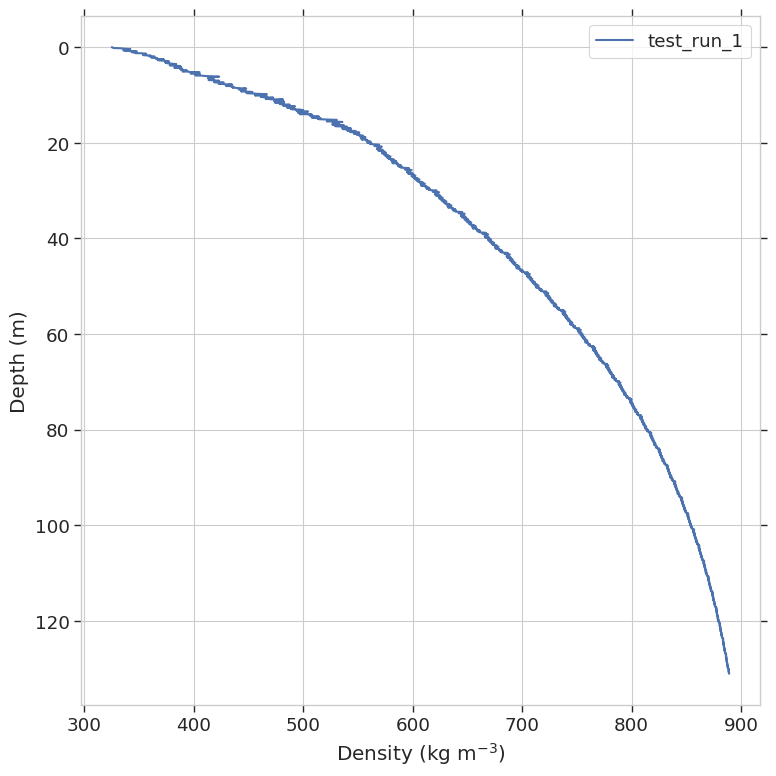

In [14]:
### Plot depth/density
# this is the density profile at the last time

f1,a1=plt.subplots(figsize=(8,8))
for rt in fns:
    a1.plot(rd[rt]['density'][-1,:],rd[rt]['depth'][-1,:],label=rt)
a1.invert_yaxis()
a1.legend()
a1.set_xlabel('Density (kg m$^{-3}$)')
a1.set_ylabel('Depth (m)')



Text(0, 0.5, 'Depth (m)')

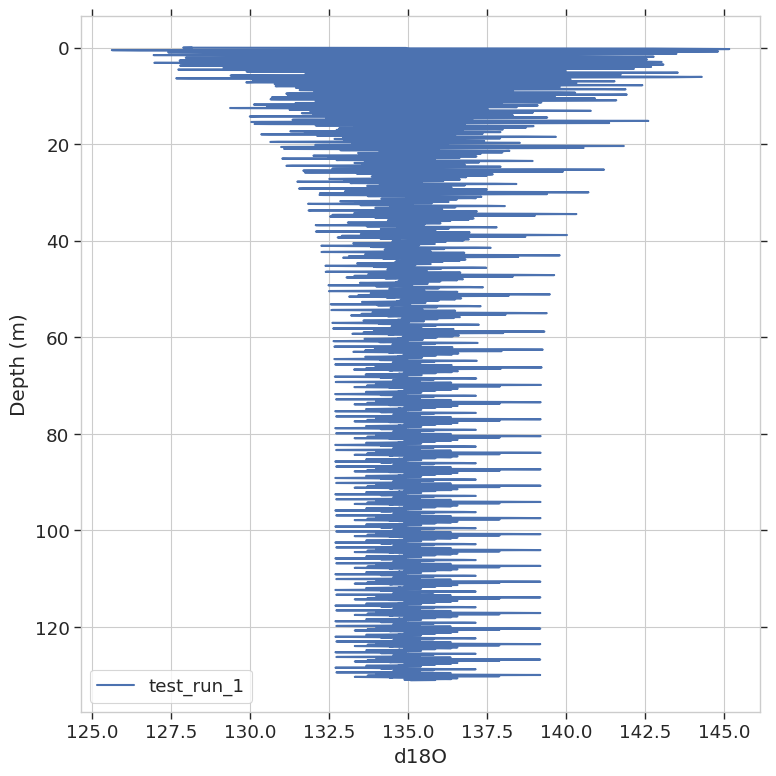

In [15]:
### Plot depth/density
f1,a1=plt.subplots(figsize=(8,8))
for rt in fns:
    a1.plot(rd[rt]['isotopes_d18O'][-1,:],rd[rt]['depth'][-1,:],label=rt)
a1.invert_yaxis()
a1.legend()
a1.set_xlabel('d18O')
a1.set_ylabel('Depth (m)')

Text(0, 0.5, 'Depth (m)')

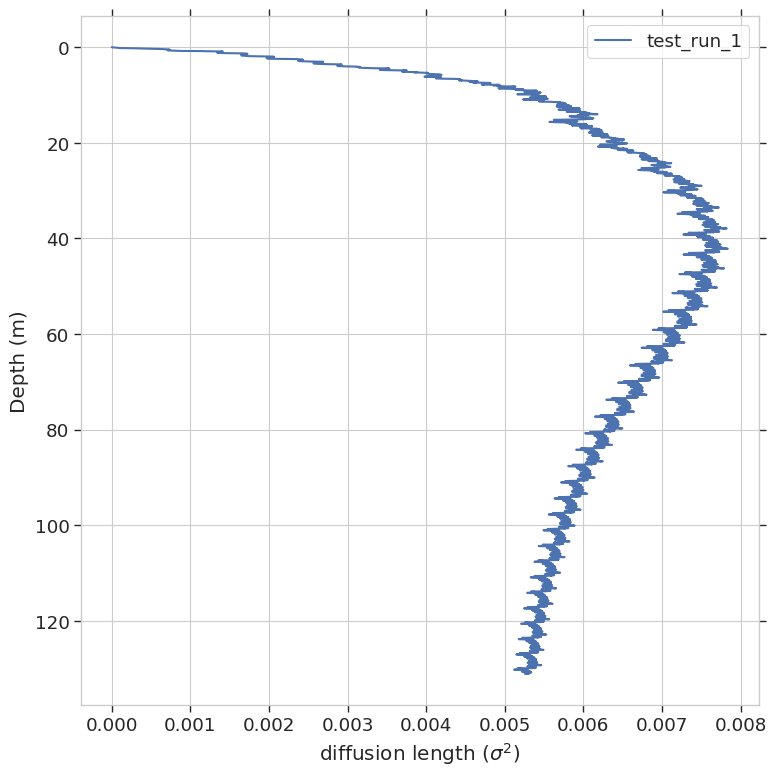

In [16]:
### Plot depth/density
f1,a1=plt.subplots(figsize=(8,8))
for rt in fns:
    a1.plot(rd[rt]['sig2_d18O'][-1,:],rd[rt]['depth'][-1,:],label=rt)
a1.invert_yaxis()
a1.legend()
a1.set_xlabel('diffusion length ($\sigma^{2}$)')
a1.set_ylabel('Depth (m)')